In [ ]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../")

In [2]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
from anchor import utils
from anchor import anchor_tabular
#from knac import KNAC
from knac_scikit import KnacSplits, KnacMerges
from knac_helpers import caption_clusters, find_centers,prepareDf2
import matplotlib.patches as patches
import matplotlib as mlp

In [3]:
import seaborn as sns

In [4]:
def plot_roc(model, dataset, features, target, saveas=None):
    from itertools import cycle

    from sklearn import svm, datasets
    from sklearn.metrics import roc_curve,auc
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import label_binarize
    from sklearn.multiclass import OneVsRestClassifier
    from scipy import interp
    
    n_classes = len(np.unique(dataset[target]))
    
    if hasattr(model ,'decision_function'):
        y_score = model.decision_function(dataset[features])
    else:
        if n_classes < 3:
            y_score = model.predict_proba(dataset[features])[::,1]
        else:
            y_score = model.predict_proba(dataset[features])
    y = label_binarize(dataset[target], classes=np.unique(dataset[target]))


    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        if n_classes > 2:
            fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])
        else:
            fpr[i], tpr[i], _ = roc_curve(dataset[target], y_score)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    if n_classes > 2:
        fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), y_score.ravel())
    else:
        fpr["micro"], tpr["micro"], _ = roc_curve(dataset[target], y_score)
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    lw = 2

    fig=plt.figure(figsize=(12,9))
    plt.plot(fpr["micro"], tpr["micro"],
           label='micro-average ROC curve (area = {0:0.2f})'
                 ''.format(roc_auc["micro"]),
           color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
           label='macro-average ROC curve (area = {0:0.2f})'
                 ''.format(roc_auc["macro"]),
           color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'gold', 'khaki', 'red', 'violet','purple'])
    for i, color in zip(range(n_classes), colors):
          plt.plot(fpr[i], tpr[i], color=color, lw=lw,
               label='ROC curve of class {0} (area = {1:0.2f})'
               ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC analysis')
    plt.legend(loc="lower right")
    plt.show()
    if saveas is not None:
        fig.savefig(saveas)

In [5]:
from sklearn.datasets import make_blobs, make_classification, make_circles
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

In [6]:
random_state = 170

# KDDM exeamples

In [16]:
X1, Y1, centers1 = make_blobs(n_samples=300, n_features=2, cluster_std=1.4, centers=3, random_state=random_state, return_centers=True)

clusterer1 = KMeans(n_clusters=4, random_state=random_state)
E1 = clusterer1.fit_predict(X1)

XX=pd.DataFrame({'x1':X1[:,0],'x2':X1[:,1],'E':E1,'C':Y1})

df1 = XX.pivot_table(index='E',columns='C',values='x1',aggfunc='count').fillna(0) #prepareDf2(E1, Y1)

knac1_merges = KnacMerges(confidence_threshold=0.9, # Assign value from  range: (0.0 ; 1.0)
                    metric='centroids_link',    # Select one of the following options ['single_link', 'average_link', 
                                              #                                       'complete_link', 'centroids_link', 'wards_link']
                    metric_weight=0.2)        # Assign value from  range: (0.0 ; 1.0)
knac_merges_recoms=knac1_merges.fit_transform(df1,data=XX[['x1','x2']].values,labels_expert=XX['E'])

In [17]:
X2, Y2, centers2 = make_blobs(n_samples=300, n_features=2, cluster_std=1.2, centers=3, random_state=random_state, return_centers=True)

clusterer2 = KMeans(n_clusters=2, random_state=random_state)
E2 = clusterer2.fit_predict(X2)

XX2=pd.DataFrame({'x1':X2[:,0],'x2':X2[:,1],'E':E2,'C':Y2})
df2 = XX2.pivot_table(index='E',columns='C',values='x1',aggfunc='count').fillna(0) #prepareDf2(E2, Y2)
knac2_splits = KnacSplits(confidence_threshold=0.9, # Assign value from  range: (0.0 ; 1.0)
    silhouette_weight=0.2)    # Assign value from  range: (0.0 ; 1.0)
knac_splits_recoms = knac2_splits.fit_transform(df2,y=None, data=XX2, labels_automatic=XX2['C'].astype(str), labels_expert=XX2['E'])


(2.0, 0.0)

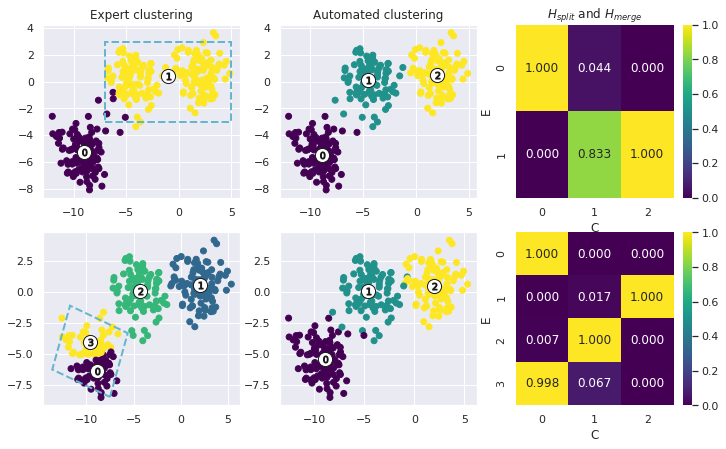

In [18]:
fig,axs = plt.subplots(2,3, figsize=(12,7))
sns.set(font_scale=1)

#merge
sns.heatmap(knac1_merges.H_conf_n, annot=True, cmap='viridis',fmt='.3f',ax=axs[1,2])
axs[1,0].scatter(X1[:,0],X1[:,1], c=E1, cmap='viridis')
axs[1,1].scatter(X1[:,0],X1[:,1], c=Y1, cmap='viridis')
axs[0,0].set(title='Expert clustering')
axs[0,1].set(title='Automated clustering')
axs[0,2].set(title='$H_{split}$ and $H_{merge}$')
axs[1,2].set_ylim([knac1_merges.H_conf_n.shape[0], 0]) # source: https://datascience.stackexchange.com/a/67741

rect = patches.Rectangle((-7.5,-8.5),5.5,6.5,angle=70,ec='c', fc="None", ls='--', linewidth=2, clip_on=False)
axs[1,0].add_patch(rect)
caption_clusters(axs[1,0], find_centers(X1, E1))
caption_clusters(axs[1,1], centers1)

#split
sns.heatmap(knac2_splits.H_conf2, annot=True, cmap='viridis',fmt='.3f',ax=axs[0,2])
axs[0,0].scatter(X2[:,0],X2[:,1], c=E2, cmap='viridis')
axs[0,1].scatter(X2[:,0],X2[:,1], c=Y2, cmap='viridis')
rect = patches.Rectangle((-7,-3),12,6,angle=0,ec='c', fc="None", ls='--', linewidth=2, clip_on=False)
axs[0,0].add_patch(rect)
caption_clusters(axs[0,0], find_centers(X2, E2))
caption_clusters(axs[0,1], centers2)
axs[0,2].set_ylim([knac2_splits.H_conf2.shape[0], 0]) # source: https://datascience.stackexchange.com/a/67741

In [10]:
fig.savefig('synthds-kddm.png')

In [19]:
#Splits recommendations
knac_splits_recoms

E
1    [(1, 2), 0.8332849823568992]
Name: split, dtype: object

In [20]:
#merge recommendations
knac_merges_recoms

,C1,C2,similarity
1,0,3,0.958983


## Explain splits
  * We explain differences between two clusters with complex model, and Anchor
  * We explain splits by building surogate decision tree on the subset containing only these splited data


### Explanation based on complex model and anchor

In [80]:
knac_splits_recoms

E
1    [(1, 2), 0.8332849823568992]
Name: split, dtype: object

In [39]:
features=['x1','x2']
target='C'

def justify_splits_anchor(expert_to_split, split_recoms, data, features, target_automatic='C'):
    model = xgb.XGBClassifier(use_label_encoder=False,eval_metric='mlogloss')
    model.fit(data[features].values,data[target_automatic])
    ds = data[data[target_automatic.isin(split_recoms)]]
    centers_anchor = ds.groupby(target_automatic).mean()
    
    explainerx = anchor_tabular.AnchorTabularExplainer(
    ds.C.to_list(),
    feature_names = centers_anchor[features].columns,

    train_data = ds[features].values)
    
    
    for idx in split_recoms:
        exp = explainerx.explain_instance(centers_anchor[features].loc[idx].values, model.predict, threshold=0.85)
        print(f'The rule for automatic cluster {idx}: %s' % (' AND '.join(exp.names())))
        print('Precision: %.2f' % exp.precision())
        print('Coverage: %.2f' % exp.coverage())
        
        
def justify_splits_tree(expert_to_split, split_recoms, data, features, target_automatic='C'):
    from sklearn import tree
    from graphviz import Source
    from IPython.display import SVG

    ds_local = data.copy()
    ds_local = ds_local[ds_local[target_automatic].isin(split_recoms)]
    centers_anchor_local = ds_local.groupby(target_automatic).mean()

    estimator_local_simple = tree.DecisionTreeClassifier(max_depth=1)
    estimator_local_simple.fit(ds_local[features], ds_local[target_automatic])


    graph = Source(tree.export_graphviz(estimator_local_simple, out_file=None
       , feature_names=features, class_names=[str(f) for f in estimator_local_simple.classes_]
       , filled = True))


    display(SVG(graph.pipe(format='svg')))

In [37]:
justify_splits(expert_to_split=1, 
               split_recoms=[1,2], 
               data=XX2, 
               features=features, 
               target_automatic='C')

The rule for automatic cluster 1: x1 <= -0.30
Precision: 0.98
Coverage: 0.50
The rule for automatic cluster 2: x1 > -0.30
Precision: 1.00
Coverage: 0.49


/home/sbk/anaconda3/envs/knac/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


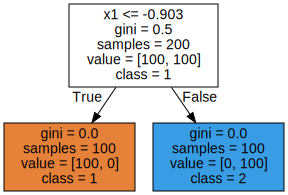

In [38]:
justify_splits_tree(expert_to_split=1, 
               split_recoms=[1,2], 
               data=XX2, 
               features=features, 
               target_automatic='C')

## Explain merges
We explain merges in the sam eway as above, but now, decision are expert labels.
We leave the decision if the condition for splitting is sufficient, or is it redundant, or artificial to an expert

In [34]:
target_sur='E'

In [81]:
knac_merges_recoms

,C1,C2,similarity
1,0,3,0.958983


In [66]:
def justify_merges_anchor(merge_recoms, data, features, target_expert='E'):
    from sklearn.preprocessing import LabelEncoder
    model_exp = xgb.XGBClassifier(use_label_encoder=False,eval_metric='mlogloss')
    le_exp = LabelEncoder()
    le_exp.fit(data[target_expert])
    model_exp.fit(data[features].values,data[target_expert])
    ds_exp = data[data[target_expert].isin(merge_recoms)]
    centers_exp = ds_exp.groupby(target_expert).mean()
    
    explainer_exp = anchor_tabular.AnchorTabularExplainer(
        le_exp.classes_,
        feature_names = centers_exp[features].columns,
        train_data = data[features].values,
        categorical_names={})
    
    
    for idx in merge_recoms:
        exp = explainer_exp.explain_instance(centers_exp[features].loc[idx].values, model_exp.predict, threshold=0.85)
        print(f'The rule for automatic cluster {idx}: %s' % (' AND '.join(exp.names())))
        print('Precision: %.2f' % exp.precision())
        print('Coverage: %.2f' % exp.coverage())

In [67]:
justify_merges_anchor(merge_recoms=[0,3], data=XX, features=features, target_expert='E')

The rule for automatic cluster 0: x2 <= -4.34 AND x1 <= -4.40
Precision: 0.80
Coverage: 0.25
The rule for automatic cluster 3: x1 <= -8.20 AND x2 > -4.34
Precision: 1.00
Coverage: 0.07


In [74]:
def justify_merges_tree(merge_recoms, data, features, target_expert='E'):
    from sklearn import tree
    from graphviz import Source
    from IPython.display import SVG
    from sklearn.preprocessing import LabelEncoder

    le_exp = LabelEncoder()
    le_exp.fit(data[target_expert])
    ds_exp = data[data[target_expert].isin(merge_recoms)]
    centers_anchor_local = ds_exp.groupby(target_expert).mean()

    estimator_local_simple_exp = tree.DecisionTreeClassifier(max_depth=1)
    estimator_local_simple_exp.fit(ds_exp[features], le_exp.transform(ds_exp[target_expert]))


    graph = Source(tree.export_graphviz(estimator_local_simple_exp, out_file=None
       , feature_names=features, class_names=[str(f) for f in estimator_local_simple_exp.classes_]
       , filled = True))


    display(SVG(graph.pipe(format='svg')))
  

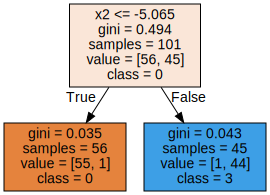

In [75]:
justify_merges_tree(merge_recoms=[0,3], data=XX, features=features, target_expert='E')